#### **Project Overview**
- Built a model to detect fraudulant transactions from a extremely imbalanced financial dataset with minority(fraud) proportion of just 0.129 %.
- Cleaned, explored and manipulated the entire data extensively on Python to make it usable for our use case.
- Investigated the data and engineered new features as and when necessary in accordance with our project requirements.
- Was able to achieve a near perfect accuracy with Precision-Recall AUC of 98.55 % on the testing set.
- Applied Synthetic Minority Over-sampling Technique (SMOTE) and other measures to overcome extreme imbalance before modelling the classifier.

##### **Project Introduction**
In this project, I'll be trying to detect fraudulant transactions from a financial dataset containing over 6 million records of transactions. The dataset is extremely imbalanced with the minority(fraud) proportion of just 0.129 % of the total number of records. We will be trying to implement various measures to tackle the challenges and arrive at an acceptable fraud detection performance. For our evaluation metric, we will not be using the commonly used accuracy and ROC AUC but instead we will be using the Precision-Recall AUC. This is because since our data is extremely imbalanced and our objective is to evaluate the detection rate, we need a metric that focusses on the recall and precision rates of the classes.

In [119]:
# importing all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, PrecisionRecallDisplay
import warnings
warnings.filterwarnings("ignore")

In [120]:
# set the figure size for visualizations
sns.set(rc={'figure.figsize':(10,8)})

In [121]:
# importing the dataset
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Features reference:

- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

In [122]:
# we check for null values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [123]:
# we check the data types
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [124]:
# we check the minority class proportion
minority_prop = round((df["isFraud"].value_counts()[1] / len(df)) * 100, 3)
print("Minority(Fraud) Proportion: ", minority_prop, " %")

Minority(Fraud) Proportion:  0.129  %


We see that we have an extremely imbalanced dataset with minority class proportion of just 0.129% of the total number of records.

##### **Data Investigation & Exploration:**

First, we will start by splitting the dataset into fraud and valid transactions datasets. Then we will be comparing the stats among each to pick up points of interest and patterns that might help us while building the detection model. We will also be discarding features that we find irrelevant to our project objective.

In [125]:
# split the dataset into fraud and valid datasets
frauddf = df[df["isFraud"] == 1]
nofrauddf = df[df["isFraud"] == 0]

##### Feature: **"step"**

In [126]:
# descriptive stats of fraud and valid df
print("Fraud DF:\n", frauddf["step"].describe().round(1), "\n\nValid DF:\n", nofrauddf["step"].describe().round(1))

Fraud DF:
 count    8213.0
mean      368.4
std       216.4
min         1.0
25%       181.0
50%       367.0
75%       558.0
max       743.0
Name: step, dtype: float64 

Valid DF:
 count    6354407.0
mean         243.2
std          142.1
min            1.0
25%          156.0
50%          239.0
75%          334.0
max          718.0
Name: step, dtype: float64


We see that the average of step is more centered in fraud dataset than that in the valid dataset. This might indicate that fraud transactions generally happen all around the clock whereas valid transactions might have some sort of frequency distribution. We will try to explore this further in detail.

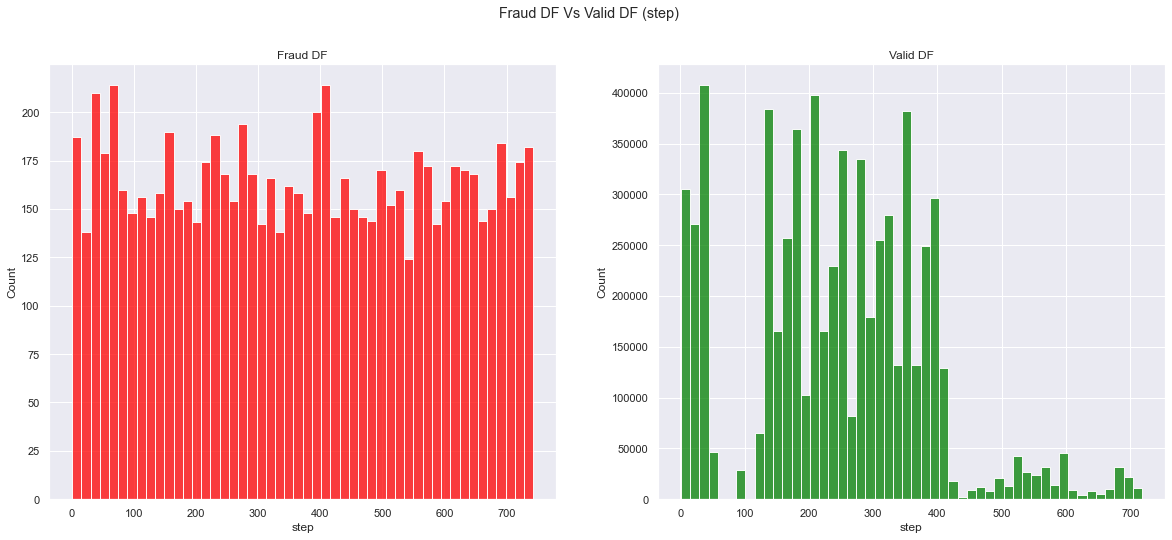

In [127]:
# we plot the histograms of both fraud and valid df step feature
fig, axes = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('Fraud DF Vs Valid DF (step)')
sns.histplot(ax=axes[0], data=frauddf["step"], bins=50, color="red")
axes[0].set_title("Fraud DF")
sns.histplot(ax=axes[1], data=nofrauddf["step"], bins=50, color="green")
axes[1].set_title("Valid DF")
plt.show()

We see that fraud transactions happen all throughout the month but valid transactions peaks throughout the first half of the month and then slacks off. This looks interesting and will be helpful so we will be including this feature in our model.

Next, we will be trying to explore comparison between fraud and valid transactions throughout the day.

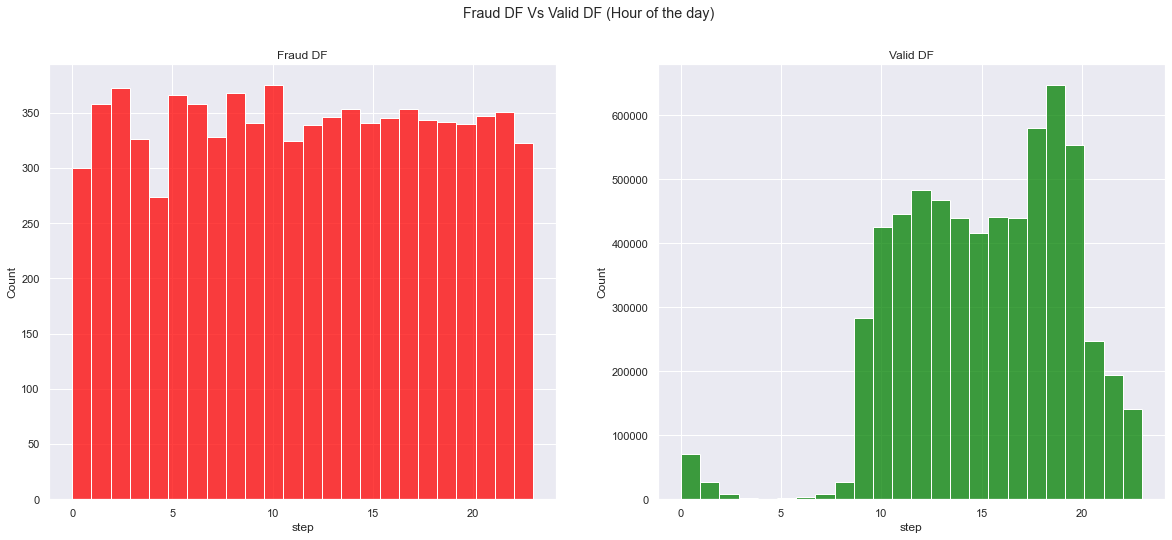

In [128]:
# we plot the histograms of both fraud and valid df hour of the day feature
fig, axes = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('Fraud DF Vs Valid DF (Hour of the day)')
sns.histplot(ax=axes[0], data=frauddf["step"]%24, bins=24, color="red")
axes[0].set_title("Fraud DF")
sns.histplot(ax=axes[1], data=nofrauddf["step"]%24, bins=24, color="green")
axes[1].set_title("Valid DF")
plt.show()

We see that fraud transactions happen all throughout the day whereas valid transactions ramps up after the initial hours of the day. This looks interesting so we will be creating a new feature "hour of the day" to include in our model.

In [129]:
# created a new feature hour of the day
df["dayhour"] = df["step"]%24

##### Feature: **"type"**

In [130]:
# we explore the value counts of the type feature in both our fraud and valid df
print("Fraud DF:\n", frauddf["type"].value_counts(), "\n\nValid DF:\n", nofrauddf["type"].value_counts())

Fraud DF:
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64 

Valid DF:
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


We see that fraud only happens in "CASH_OUT" and "TRANSFER" transactions. On the basis of this information, we will be dropping all the other types of transactions from our dataset as they serve no purpose in fraud detection.

In [131]:
# dropped irrelevant types of transactions
df = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [132]:
# we again initialize the fraud and valid transactions df
frauddf = df[df["isFraud"] == 1]
nofrauddf = df[df["isFraud"] == 0]

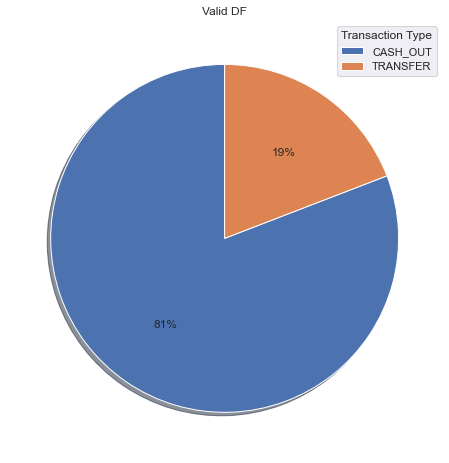

In [133]:
# pie chart of transaction types of valid df
plt.pie(x=nofrauddf['type'].value_counts(), startangle=90, shadow=True, autopct='%1.0f%%')
plt.title("Valid DF")
plt.legend(title="Transaction Type", loc="upper right", labels=["CASH_OUT", "TRANSFER"])
plt.show()

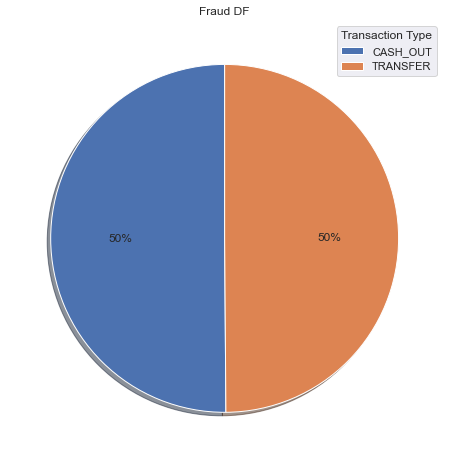

In [134]:
# pie chart of transaction types of fraud df
plt.pie(x=frauddf['type'].value_counts(), startangle=90, shadow=True, autopct='%1.0f%%')
plt.title("Fraud DF")
plt.legend(title="Transaction Type", loc="upper right", labels=["CASH_OUT", "TRANSFER"])
plt.show()

##### Feature: **"amount"** and all related features

In [135]:
# we print the descriptive stats of the fraud and valid df amount feature
print("Fraud DF:\n", frauddf["amount"].describe().round(1), "\n\nValid DF:\n", nofrauddf["amount"].describe().round(1))

Fraud DF:
 count        8213.0
mean      1467967.3
std       2404252.9
min             0.0
25%        127091.3
50%        441423.4
75%       1517771.5
max      10000000.0
Name: amount, dtype: float64 

Valid DF:
 count     2762196.0
mean       314115.5
std        877144.1
min             0.0
25%         82908.2
50%        171034.5
75%        305994.2
max      92445516.6
Name: amount, dtype: float64


We see some interesting points:
- Fraud transactions amount is capped at exactly 10 million units whereas valid transactions amount goes all the way upto 92 million units.
- Mean of fraud and valid transaction amount is way higher than their respective median indicating high presence of outliers.
- Fraud transaction amounts are generally higher than valid transaction amounts.

In [136]:
# we print the first 5 transactions
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dayhour
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


We see that **"newbalanceOrig"** + **"amount"** should equal to **"oldbalanceOrg"** and also **"oldbalanceDest"** + **"amount"** should equal to **"newbalanceDest"**. We will try to verify this before proceeding ahead and also check if there are any discrepencies.

In [137]:
# we verify if new balance origin + amount does equal to old balance origin
print("Percentages: \n", ((df["newbalanceOrig"] + df["amount"]) == df["oldbalanceOrg"]).value_counts(normalize=True).round(2)*100)

Percentages: 
 False    91.0
True      9.0
dtype: float64


We see that only 9% of the data has no errors in the details related to origin balances and amount. This looks very interesting so we will create a new feature "origin error amount" in our model.

In [138]:
# created a new feature origin error
df["origin_error"] = (df["newbalanceOrig"] + df["amount"]) - df["oldbalanceOrg"]

Next, we will check the same for destination balances and amount.

In [139]:
# we verify if old balance destination + amount does equal to new balance destination
print("Percentages: \n", ((df["oldbalanceDest"] + df["amount"]) == df["newbalanceDest"]).value_counts(normalize=True).round(2)*100)

Percentages: 
 True     58.0
False    42.0
dtype: float64


We see that 42% of the data has errors in the details related to destination balances and amount. Similarly, we will again create a new feature "destination error amount" in our model.

In [140]:
# created a new feature destination error
df["dest_error"] = (df["oldbalanceDest"] + df["amount"]) - df["newbalanceDest"]

##### Feature: **"nameOrig"** and **"nameDest"**

In [141]:
# we check transactions from new origin names and existing origin names
print("Total Origin Names:", len(df["nameOrig"]))
print("Unique Origin Names:", len(df["nameOrig"].unique()))
print("Transactions from existing Origin Names:", len(df["nameOrig"]) - len(df["nameOrig"].unique()))

Total Origin Names: 2770409
Unique Origin Names: 2768630
Transactions from existing Origin Names: 1779


In [142]:
# we check transactions to new destination names and existing destination names
print("Total Destination Names:", len(df["nameDest"]))
print("Unique Destination Names:", len(df["nameDest"].unique()))
print("Transactions to existing Destination Names:", len(df["nameDest"]) - len(df["nameDest"].unique()))

Total Destination Names: 2770409
Unique Destination Names: 509565
Transactions to existing Destination Names: 2260844


We see that there are very few transactions that started from existing origin names but there are quite a lot of transactions that were made to existing destination names.

In [143]:
# we check if there are any transactions with origin name of initials other than "C"
print("""Number of Origin Names without the initial of "C":""", len(df[~df["nameOrig"].str.contains("C")]))

Number of Origin Names without the initial of "C": 0


In [144]:
# we check if there are any transactions with destination name of initials other than "C"
print("""Number of Destination Names without the initial of "C":""", len(df[~df["nameDest"].str.contains("C")]))

Number of Destination Names without the initial of "C": 0


We see that this two features will not show any significance in detecting fraud transactions so we will be dropping them from our model.

In [145]:
# dropped nameOrig and nameDest
df.drop(columns=["nameOrig", "nameDest"], axis=1, inplace=True)

##### Feature: **"isFlaggedFraud"**

In [148]:
# we check the value counts
df["isFlaggedFraud"].value_counts()

0    2770393
1         16
Name: isFlaggedFraud, dtype: int64

We see that this feature is extremely minuscule and will most likely not be of any significance. We will try to check all the transactions that are positive for this feature.

In [149]:
# all transactions where isFlaggedFraud is 1
df[df["isFlaggedFraud"] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dayhour,origin_error,dest_error
2736446,212,TRANSFER,4953893.08,4953893.08,4953893.08,0.0,0.0,1,1,20,4953893.08,4953893.08
3247297,250,TRANSFER,1343002.08,1343002.08,1343002.08,0.0,0.0,1,1,10,1343002.08,1343002.08
3760288,279,TRANSFER,536624.41,536624.41,536624.41,0.0,0.0,1,1,15,536624.41,536624.41
5563713,387,TRANSFER,4892193.09,4892193.09,4892193.09,0.0,0.0,1,1,3,4892193.09,4892193.09
5996407,425,TRANSFER,10000000.00,19585040.37,19585040.37,0.0,0.0,1,1,17,10000000.00,10000000.00
5996409,425,TRANSFER,9585040.37,19585040.37,19585040.37,0.0,0.0,1,1,17,9585040.37,9585040.37
6168499,554,TRANSFER,3576297.10,3576297.10,3576297.10,0.0,0.0,1,1,2,3576297.10,3576297.10
6205439,586,TRANSFER,353874.22,353874.22,353874.22,0.0,0.0,1,1,10,353874.22,353874.22
6266413,617,TRANSFER,2542664.27,2542664.27,2542664.27,0.0,0.0,1,1,17,2542664.27,2542664.27
6281482,646,TRANSFER,10000000.00,10399045.08,10399045.08,0.0,0.0,1,1,22,10000000.00,10000000.00


We see that all these transactions are also marked as fraud. So, we will proceed to drop this feature from our model as it does not show any significance.

In [150]:
# dropped isFlaggedFraud feature
df.drop(columns=["isFlaggedFraud"], axis=1, inplace=True)

##### **Model Building:**

**Label Encoding**

First, we will start by label encoding our categorical features. Since, we have only one categorical feature with simple categories, we can do it manually.

In [151]:
df["type"] = df["type"].replace({"TRANSFER":0, "CASH_OUT":1}) # label encoded manually

**Scaling**

We will use standard scaler to scale our dataset and define the X and y.

In [152]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["isFraud"]))
y = df["isFraud"]

**Train Test Split**

In [153]:
# we split our dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # we use stratify as y so that our minority class proportion is maintained in both training and testing sets

**Synthetic Minority Over-sampling Technique (SMOTE)**

We will be using SMOTE to balance the classes in our dataset. SMOTE is a widely used technique that works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [154]:
# we use SMOTE to balance the classes in our training set
sm = SMOTE(random_state=45)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [160]:
# we check if the classes are balanced
print("Percentages of classes 0 and 1:\n", y_res.value_counts(normalize=True)*100)

Percentages of classes 0 and 1:
 0    50.0
1    50.0
Name: isFraud, dtype: float64


We see that our classes are balanced and hence we proceed towards training the model.

**Model Selection**

We decide to use Random Forest Classifier for our model because it is extremely suitable for huge datasets like ours. Also, it is very flexible, easy to understand and performs pretty solid out of the box without much hyper parameter tuning. If we are unable to get the satisfactory results, we might proceed to try other ML algorithms.

In [161]:
# we initialize and fit the data on our training set
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_res, y_res)

RandomForestClassifier(n_jobs=-1)

**Evaluation**

For our evaluation metric, we will not be using the commonly used accuracy and ROC AUC but instead we will be using the Precision-Recall AUC. This is because since our data is extremely imbalanced and our objective is to evaluate the detection rate, we need a metric that focusses on the recall and precision rates of the classes.

In [162]:
# we predict our testing set with the model and print the classification report to check the evaluation markers
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      0.99      0.99      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [170]:
# we check the precision-recall AUC
print("Precision-Recall AUC:", ((average_precision_score(y_test, y_pred))*100).round(2), "%")

Precision-Recall AUC: 98.55 %


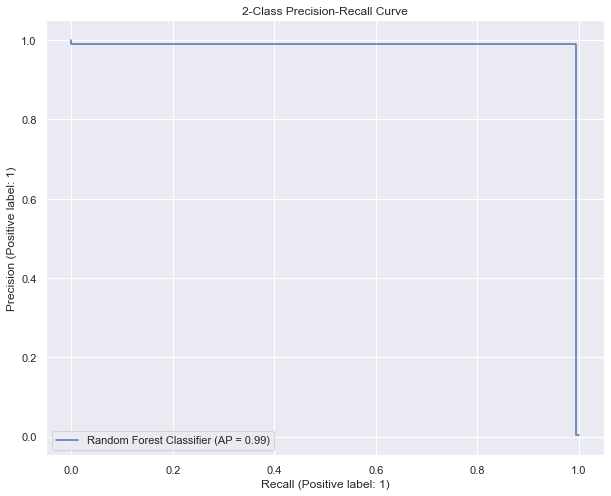

In [182]:
# we plot the precision recall curve
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Random Forest Classifier")
display.ax_.set_title("2-Class Precision-Recall Curve")
plt.show()

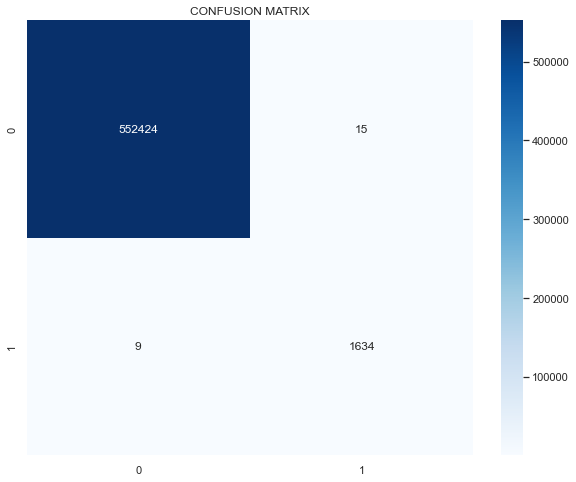

In [178]:
# we plot and check the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("CONFUSION MATRIX")
plt.show()

We see that we have a pretty solid model with near perfect evaluation scores. Hence, we will not try to perform any hyper parameter tuning or any further changes.

##### **Conclusion:**

We see that we have achieved fruitful results. We were able to build a model from an extremely imbalanced dataset that can detect fraud transactions with near perfect accuracy. This concludes our project till here.

Data Source: [Link](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset)

Thank you for reading!! :D

Rishiraj Chowdhury (rishiraj5565@gmail.com)